In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCost
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *

In [68]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.group_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-24 16:23:01]: Using numpy backend on /CPU:0


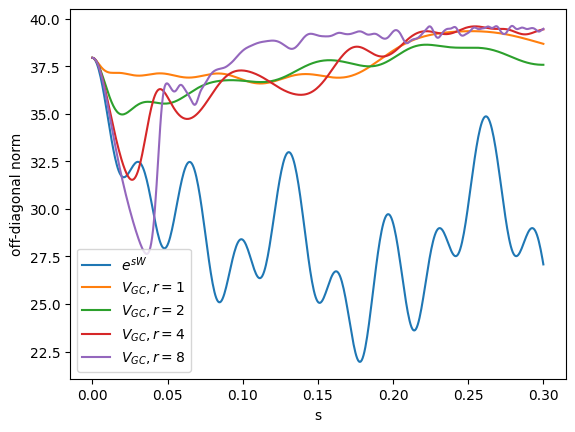

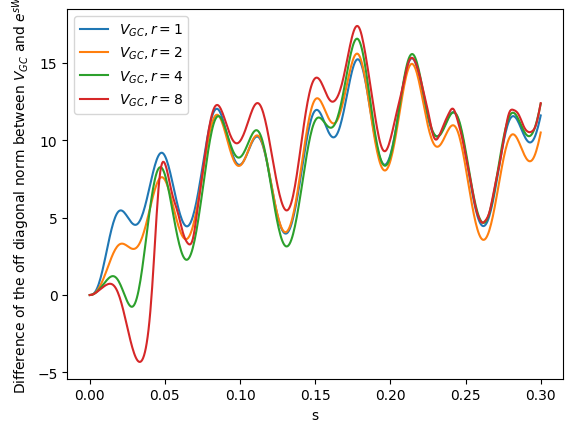

In [83]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
s_space = np.linspace(1e-5, 0.3, 500)
r = np.array([1,2,4,8])
off_diagonal_norm_diff = np.empty((500,len(r)+1))

for s in range(len(s_space)):
    for i in range(len(r)):
        dbi_eval = deepcopy(dbi)
        dbi_eval.mode = DoubleBracketGeneratorType.group_commutator
        for j in range(r[i]):
            dbi_eval(np.sqrt(s_space[s]/r[i]),d=d)
        off_diagonal_norm_diff[s,i+1] = dbi_eval.off_diagonal_norm
    dbi_eval = deepcopy(dbi)
    dbi_eval.mode = DoubleBracketGeneratorType.single_commutator
    dbi_eval(s_space[s],d=d)
    off_diagonal_norm_diff[s,0] = dbi_eval.off_diagonal_norm
   
    

plt.figure()
plt.plot(s_space, off_diagonal_norm_diff[:,0],label=r'$e^{sW}$')
for i in range(len(r)):
    plt.plot(s_space, off_diagonal_norm_diff[:,i+1],label=r'$V_{GC}, r = $' + str(r[i]))
plt.xlabel('s')
plt.ylabel('off-diagonal norm')
plt.legend()

plt.figure()
for i in range(len(r)):
    plt.plot(s_space, off_diagonal_norm_diff[:,i+1]-off_diagonal_norm_diff[:,0],label=r'$V_{GC}, r = $' + str(r[i]))
plt.xlabel('s')
plt.ylabel('Difference of the off diagonal norm between $V_{GC}$ and $e^{sW}$')
plt.legend()
plt.show()


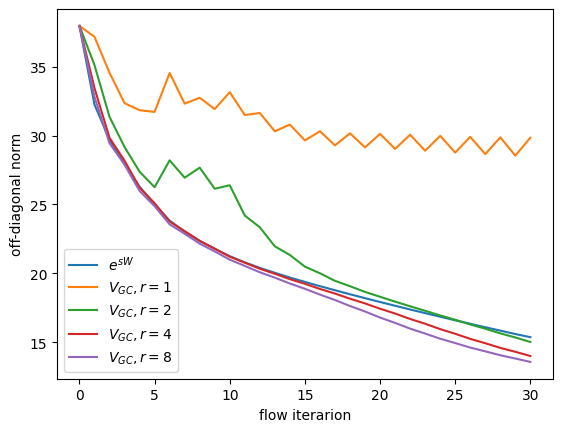

In [82]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
flows = 30
r = np.array([1,2,4,8])
off_diagonal_norm_diff = np.empty((1+flows,len(r)+1))
s = np.empty(flows)
dbi_eval = deepcopy(dbi)
off_diagonal_norm_diff[0,:] = dbi_eval.off_diagonal_norm
for i in range(flows):
    dbi_eval.mode = DoubleBracketGeneratorType.single_commutator
    s[i] = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
    dbi_eval(s[i],d=d)
    off_diagonal_norm_diff[i+1,0] = dbi_eval.off_diagonal_norm

for j in range(len(r)):
    dbi_eval = deepcopy(dbi)
    dbi_eval.mode = DoubleBracketGeneratorType.group_commutator
    for i in range(flows):
        for k in range(r[j]):
            dbi_eval(np.sqrt(s[i]/r[j]),d=d)
        off_diagonal_norm_diff[i+1,j+1] = dbi_eval.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm_diff[:,0],label=r'$e^{sW}$')
for i in range(len(r)):
    plt.plot(off_diagonal_norm_diff[:,i+1],label=r'$V_{GC}, r = $' + str(r[i]))
plt.xlabel('flow iterarion')
plt.ylabel('off-diagonal norm')
plt.legend()